# BERT Model

## Imports

In [ ]:
# !pip install transformers datasets scikit-learn pandas torch matplotlib seaborn numpy

  Using cached numpy-2.2.4-cp311-cp311-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   --------- ------------------------------ 2.4/10.4 MB 12.2 MB/s eta 0:00:01
   ------------------ --------------------- 4.7/10.4 MB 11.4 MB/s eta 0:00:01
   --------------------------- ------------ 7.1/10.4 MB 11.8 MB/s eta 0:00:01
   ----------------------------------- ---- 9.2/10.4 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.1 MB 12.2 MB/s eta 0:00:01
   ---------------- ----------------------- 4.7/11.1 MB 12.4 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.1 MB 12.1 MB/s eta 0:00:01
   ---------------------------------- ----- 9.7/11.1 MB 12.1 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 11.8 MB/s eta 0:00:00
   -----

In [35]:
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn
import numpy as np
from torch.nn.functional import softmax


In [36]:
torch.manual_seed(21)
    
# Set device for running model (GPU if available, else CPU)
device = (
    "mps" 
    if torch.backends.mps.is_available()
    else "cuda" 
    if torch.cuda.is_available() 
    else "cpu"
)
device = torch.device(device)
print(f"Using device: {device}")

Using device: cpu


## Data

In [37]:
dataset_path = './data/final_dataset_cleaned.csv'

In [38]:
data = pd.read_csv(dataset_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3993 entries, 0 to 3992
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3993 non-null   object 
 1   description  3993 non-null   object 
 2   amount       3993 non-null   float64
 3   type         3993 non-null   object 
 4   category     3993 non-null   object 
 5   explanation  3993 non-null   object 
dtypes: float64(1), object(5)
memory usage: 187.3+ KB


In [39]:
data = data.dropna()
data = data.drop_duplicates()

In [40]:
labels = data['category'].unique()

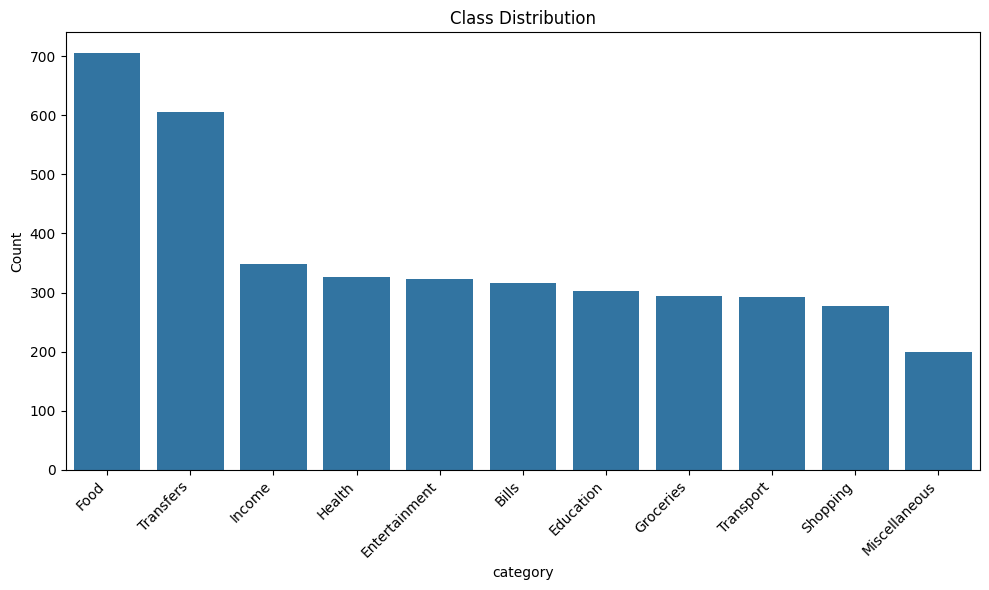

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count classes
class_counts = data['category'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)

# Automatically align tick labels with class names
plt.xticks(rotation=45, ha='right')  # Rotates for better visibility
plt.ylabel("Count")
plt.title("Class Distribution")
plt.tight_layout()
plt.show()


## Model

In [42]:
# Encode labels
label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["category"])
num_labels = len(label_encoder.classes_)

In [43]:
# Split into train/test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["description"].tolist(),
    data["label"].tolist(),
    test_size=0.2,
    random_state=42
)

In [44]:
bert_model = "yiyanghkust/finbert-pretrain"

# Tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model)

In [45]:
class TransactionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TransactionDataset(train_texts, train_labels, tokenizer)
val_dataset = TransactionDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [46]:
# Model
model = BertForSequenceClassification.from_pretrained(bert_model, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
class BERTClassifier(nn.Module):
    def __init__(self, pretrained_model=bert_model, n_classes=num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(p=0.4)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropped = self.dropout(pooled_output)
        return self.classifier(dropped)

In [48]:
# Training setup
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
epoch_no = 10
num_training_steps = len(train_loader) * epoch_no  
# lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
best_loss = float('inf')
patience = 2

model_path = "./"

In [ ]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        logits = outputs.logits 
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    true_labels, predictions = [], []
    eval_loss = 0 

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluatin g"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs.logits 
            loss = loss_fn(logits, labels)

            eval_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return {
        "eval_loss": eval_loss / len(loader),
        "accuracy": accuracy_score(true_labels, predictions),
        "precision": precision_score(true_labels, predictions, average='weighted'),
        "recall": recall_score(true_labels, predictions, average='weighted'),
        "f1": f1_score(true_labels, predictions, average='weighted')    
    }


In [50]:
# Run training
for epoch in range(epoch_no):
    print(f"\nEpoch {epoch+1}")
    loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Train Loss: {loss:.4f}")
    metrics = evaluate(model, val_loader, device)
    val_loss = metrics['eval_loss']
    print(f"Validation Loss: {metrics['eval_loss']:.4f}")
    print(f"Validation Accuracy: {metrics['accuracy']:.4f}, F1 Score: {metrics['f1']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")

    # Check if this is the best model so far
    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_bert_model.pt")
        print(f"New best model saved to {model_path}")
    else:
        early_stopping_counter += 1
        print(f" No improvement. Early stopping counter: {early_stopping_counter}/{patience}")

    # Early stopping trigger
    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break


Epoch 1


Training: 100%|██████████| 200/200 [13:22<00:00,  4.01s/it]


Train Loss: 0.9990


Evaluating: 100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Validation Loss: 0.3684
Validation Accuracy: 0.8999, F1 Score: 0.8998
Precision: 0.9110, Recall: 0.8999
New best model saved to ./

Epoch 2


Training: 100%|██████████| 200/200 [12:45<00:00,  3.83s/it]


Train Loss: 0.2394


Evaluating: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Validation Loss: 0.1859
Validation Accuracy: 0.9499, F1 Score: 0.9493
Precision: 0.9512, Recall: 0.9499
New best model saved to ./

Epoch 3


Training: 100%|██████████| 200/200 [12:31<00:00,  3.76s/it]


Train Loss: 0.1071


Evaluating: 100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Validation Loss: 0.1553
Validation Accuracy: 0.9599, F1 Score: 0.9592
Precision: 0.9616, Recall: 0.9599
New best model saved to ./

Epoch 4


Training: 100%|██████████| 200/200 [12:46<00:00,  3.83s/it]


Train Loss: 0.0734


Evaluating: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Validation Loss: 0.1551
Validation Accuracy: 0.9599, F1 Score: 0.9598
Precision: 0.9613, Recall: 0.9599
New best model saved to ./

Epoch 5


Training: 100%|██████████| 200/200 [12:32<00:00,  3.76s/it]


Train Loss: 0.0512


Evaluating: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Validation Loss: 0.1547
Validation Accuracy: 0.9662, F1 Score: 0.9658
Precision: 0.9671, Recall: 0.9662
New best model saved to ./

Epoch 6


Training: 100%|██████████| 200/200 [12:16<00:00,  3.68s/it]


Train Loss: 0.0437


Evaluating: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Validation Loss: 0.1746
Validation Accuracy: 0.9625, F1 Score: 0.9627
Precision: 0.9647, Recall: 0.9625
 No improvement. Early stopping counter: 1/2

Epoch 7


Training: 100%|██████████| 200/200 [13:59<00:00,  4.20s/it]


Train Loss: 0.0449


Evaluating: 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


Validation Loss: 0.1477
Validation Accuracy: 0.9700, F1 Score: 0.9699
Precision: 0.9701, Recall: 0.9700
New best model saved to ./

Epoch 8


Training: 100%|██████████| 200/200 [14:34<00:00,  4.37s/it]


Train Loss: 0.0307


Evaluating: 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


Validation Loss: 0.1609
Validation Accuracy: 0.9662, F1 Score: 0.9662
Precision: 0.9668, Recall: 0.9662
 No improvement. Early stopping counter: 1/2

Epoch 9


Training: 100%|██████████| 200/200 [14:40<00:00,  4.40s/it]


Train Loss: 0.0280


Evaluating: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]

Validation Loss: 0.1769
Validation Accuracy: 0.9599, F1 Score: 0.9598
Precision: 0.9632, Recall: 0.9599
 No improvement. Early stopping counter: 2/2
Early stopping triggered.


In [55]:
# Step 2: Load Model Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier()
model.load_state_dict(torch.load("best_bert_model.pt", weights_only=True, map_location=device))
model.to(device)
model.eval()

# Step 3: Load Tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model)

# Step 4: Prediction Function
def predict_transaction(text, model, tokenizer, max_length=128):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    return pred_class, probs.cpu().numpy()[0]

# Step 5: Test
text = "DEBIT PURCHASE 12/03/24 Grab"
pred, probs = predict_transaction(text, model, tokenizer)
label = label_encoder.inverse_transform([pred])[0]

print("Predicted class:", label)
print("Class confidence scores:", probs)


Predicted class: Transport
Class confidence scores: [7.1496703e-04 2.9567006e-04 2.5141818e-04 1.4428825e-04 2.3037042e-04
 4.9963698e-04 2.8153448e-04 3.0300600e-04 4.2175353e-04 1.4690736e-04
 9.9671054e-01]


Best BERT model is stored on GDrive for easier access, due to large file size. 